In [ ]:
#Wczytanie bibliotek
import pandas as pd
import numpy as np
import requests
import io
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway
from IPython.display import display, Markdown
import os


In [ ]:
# 1. Ładowanie danych
github_excel_url = 'https://raw.githubusercontent.com/MatiMajewski/Beginners/refs/heads/main/RYNEK_NIER.xlsx'
response = requests.get(github_excel_url)
df_org = pd.read_excel(io.BytesIO(response.content), header=0)

df = df_org.copy()

In [ ]:
# 2. Czyszczenie danych
print("--- INFO O STRUKTURZE ---")
print(df.info())

num_hyphens = df['Wartosc'].astype(str).str.contains('-').sum()
print(f"\nLiczba wartości z '-' w kolumnie 'Wartosc': {num_hyphens}")

df['Wartosc'] = df['Wartosc'].astype(str).str.replace('-', '0', regex=False)
df['cena_numeric'] = pd.to_numeric(df['Wartosc'], errors='coerce')

df_clean = df.dropna(subset=['cena_numeric'])

print("\n--- BRAKI W DANYCH ---")
print(df.isnull().sum())

zero_price_rows = df_clean[df_clean['cena_numeric'] == 0]
zero_counts_by_market = zero_price_rows.groupby('Transakcje rynkowe').size().reset_index(name='Liczba_zerowych_cen')

print("Liczba zerowych cen w podziale na typ transakcji rynkowej:")
display(zero_counts_by_market)

initial_rows_in_df_clean = len(df_clean)
df_clean = df_clean[df_clean['cena_numeric'] != 0].copy()
print("------------------------------------------------------------")
print(f"Liczba wierszy w df_clean przed usunięciem zer: {initial_rows_in_df_clean}")
print(f"Liczba wierszy w df_clean po usunięciu zer: {len(df_clean)}")

print("------------------------------------------------------------")
print("\n--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---")
print(df['Transakcje rynkowe'].unique())

,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5449.0,3451.77,1464.32,957.0,2483.00,3067.0,4088.00,16144.0
rynek pierwotny,4101.0,4419.51,1579.29,2018.0,3423.00,4067.0,5001.00,27720.0
rynek wtórny,5446.0,3261.27,1422.31,957.0,2335.25,2855.0,3829.75,15462.0


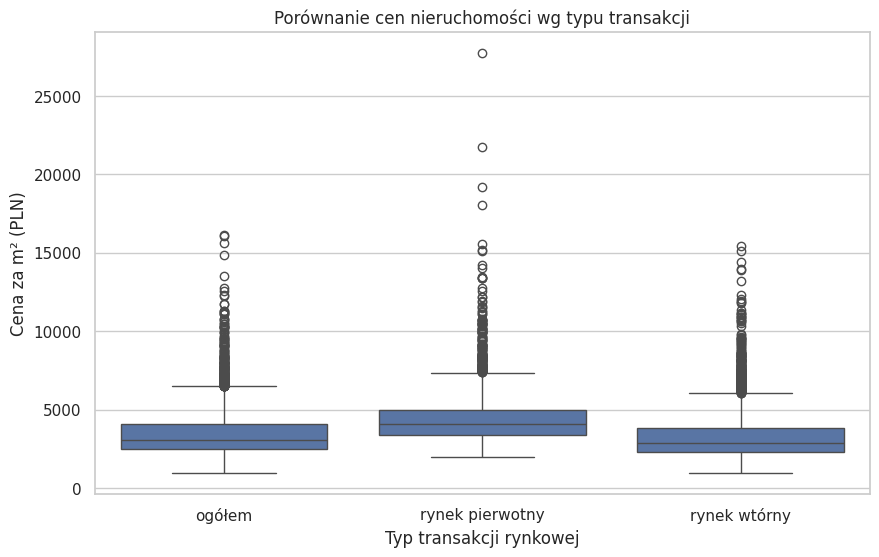

WNIOSKI: Wykres pudełkowy ujawnia liczne wartości odstające (outliery) powyżej górnego wąsa,
szczególnie na rynku wtórnym i ogółem. Sugeruje to obecność segmentu premium lub błędów,
co uzasadnia konieczność filtrowania danych do dalszych analiz statystycznych.
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5400.0,3384.84,1279.03,957.0,2477.0,3054.0,4061.75,9026.0
rynek pierwotny,4029.0,4293.84,1213.25,2018.0,3417.0,4044.0,4939.00,9023.0
rynek wtórny,5407.0,3205.13,1255.74,957.0,2332.0,2849.0,3807.00,9021.0


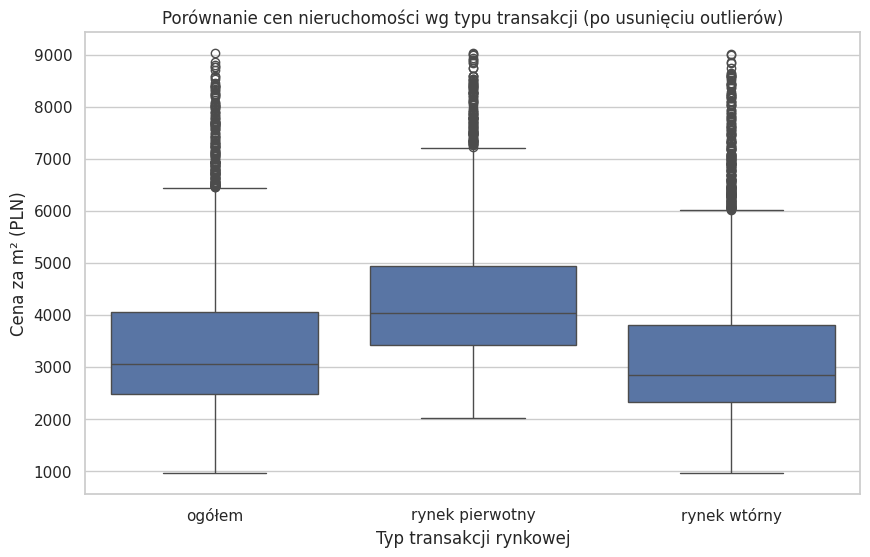

WNIOSKI: Po usunięciu outlierów widać, że rynek pierwotny posiada nie tylko wyższą medianę,
ale i większy rozstęp międzykwartylny (szersze pudełko) niż rynek wtórny.
Oznacza to większe zróżnicowanie cenowe ofert deweloperskich w porównaniu do mieszkań z drugiej ręki.


In [16]:
# 3. Statystyki opisowe i usuwanie outlierów
stats_desc = df_clean.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
display(stats_desc)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()
print("WNIOSKI: Wykres pudełkowy ujawnia liczne wartości odstające (outliery) powyżej górnego wąsa,")
print("szczególnie na rynku wtórnym i ogółem. Sugeruje to obecność segmentu premium lub błędów,")
print("co uzasadnia konieczność filtrowania danych do dalszych analiz statystycznych.")

Q1 = df_clean['cena_numeric'].quantile(0.15)
Q3 = df_clean['cena_numeric'].quantile(0.85)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_outliers = df_clean[(df_clean['cena_numeric'] >= lower_bound) & (df_clean['cena_numeric'] <= upper_bound)].copy()

stats_desc = df_outliers.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print("------------------------------------------------------------")
display(stats_desc)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_outliers, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji (po usunięciu outlierów)")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()
print("WNIOSKI: Po usunięciu outlierów widać, że rynek pierwotny posiada nie tylko wyższą medianę,")
print("ale i większy rozstęp międzykwartylny (szersze pudełko) niż rynek wtórny.")
print("Oznacza to większe zróżnicowanie cenowe ofert deweloperskich w porównaniu do mieszkań z drugiej ręki.")

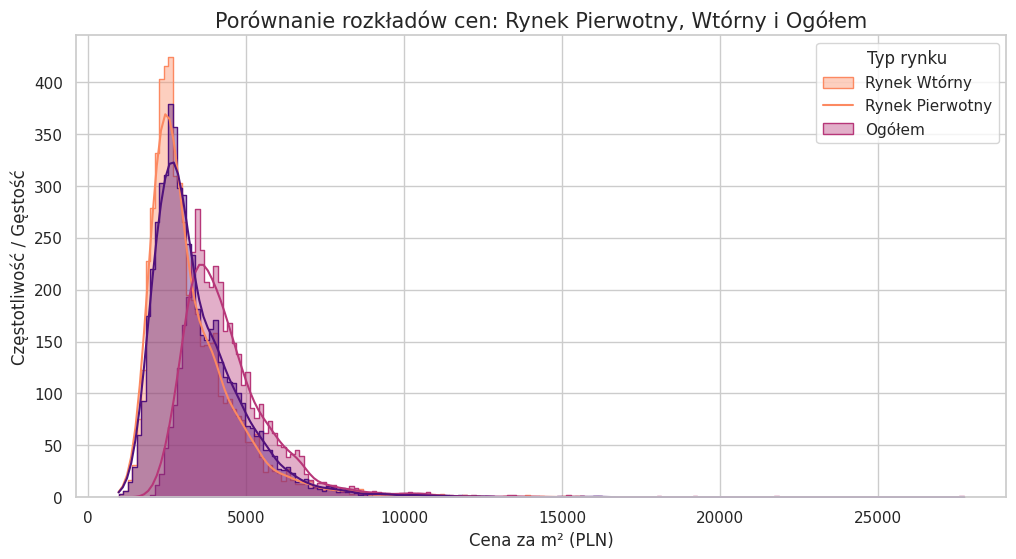

WNIOSKI: Rozkłady są wyraźnie asymetryczne prawostronnie (dodatnio skośne).
Krzywa KDE dla rynku pierwotnego jest przesunięta w prawo względem wtórnego, co potwierdza,
że nowe mieszkania stanowią droższy segment rynku o innej strukturze cenowej.
------------------------------------------------------------


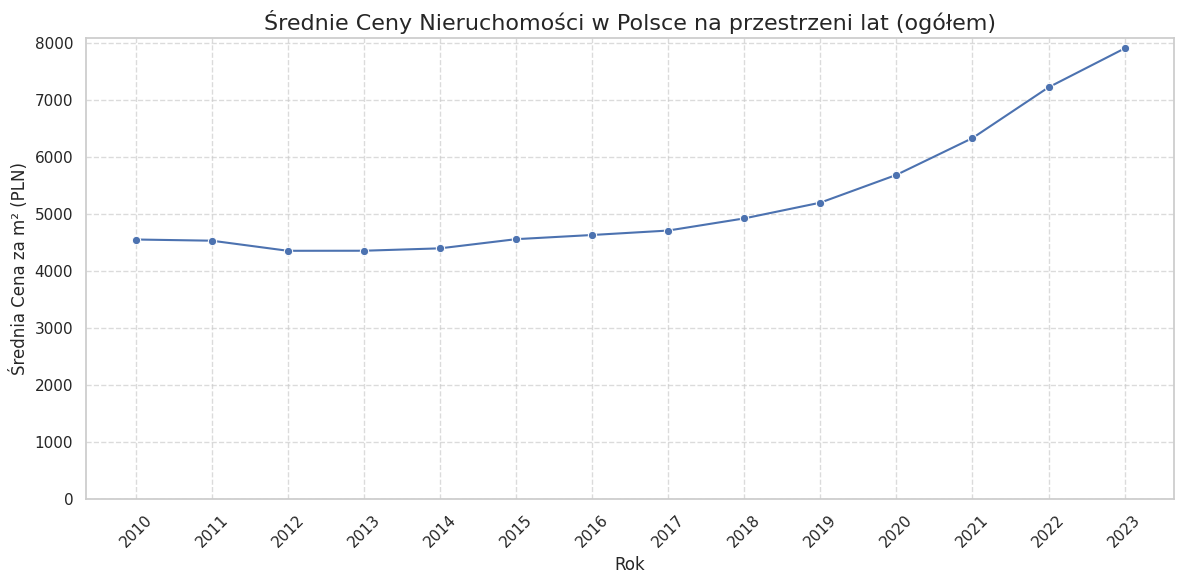

WNIOSKI: Trend liniowy pokazuje stabilny wzrost cen do około 2017 roku, po którym nastąpiło
wyraźne przyspieszenie dynamiki wzrostów. Świadczy to o gwałtownej aprecjacji wartości nieruchomości w ostatnich latach.
------------------------------------------------------------
------------------------------------------------------------


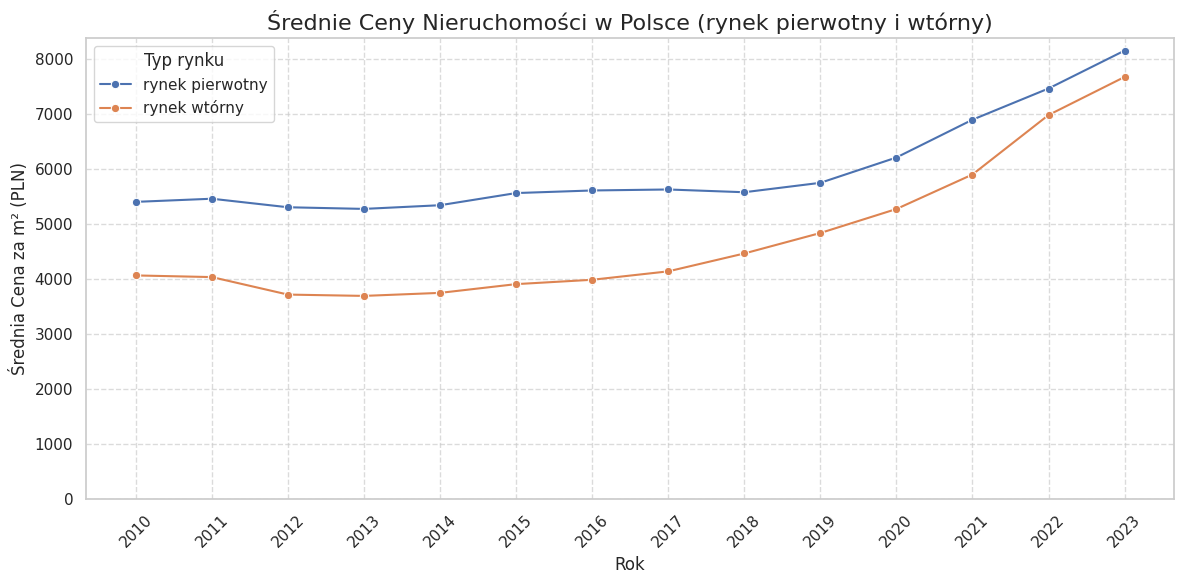

WNIOSKI: Rynek pierwotny konsekwentnie utrzymuje premię cenową nad wtórnym.
Obie serie czasowe są silnie skorelowane, co sugeruje, że czynniki makroekonomiczne
oddziałują na oba segmenty rynku w podobny sposób, zachowując stały dystans cenowy.


In [15]:
# 4. Wizualizacja rozkładu danych
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

plot_data = df_clean

sns.histplot(
    data=plot_data,
    x='cena_numeric',
    hue='Transakcje rynkowe',
    kde=True,
    element="step",
    palette='magma',
    alpha=0.4
)

plt.title('Porównanie rozkładów cen: Rynek Pierwotny, Wtórny i Ogółem', fontsize=15)
plt.xlabel('Cena za m² (PLN)', fontsize=12)
plt.ylabel('Częstotliwość / Gęstość', fontsize=12)
plt.legend(title='Typ rynku', labels=['Rynek Wtórny', 'Rynek Pierwotny', 'Ogółem'])
plt.show()
print("WNIOSKI: Rozkłady są wyraźnie asymetryczne prawostronnie (dodatnio skośne).")
print("Krzywa KDE dla rynku pierwotnego jest przesunięta w prawo względem wtórnego, co potwierdza,")
print("że nowe mieszkania stanowią droższy segment rynku o innej strukturze cenowej.")

print("------------------------------------------------------------")

df_polska = df_clean[
    (df_clean['Nazwa'] == 'POLSKA') &
    (df_clean['Transakcje rynkowe'] == 'ogółem')
].copy()

prices_polska_yearly = df_polska.groupby('Rok')['cena_numeric'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=prices_polska_yearly, x='Rok', y='cena_numeric', marker='o')
plt.title('Średnie Ceny Nieruchomości w Polsce na przestrzeni lat (ogółem)', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Średnia Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(prices_polska_yearly['Rok'].unique(), rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
print("WNIOSKI: Trend liniowy pokazuje stabilny wzrost cen do około 2017 roku, po którym nastąpiło")
print("wyraźne przyspieszenie dynamiki wzrostów. Świadczy to o gwałtownej aprecjacji wartości nieruchomości w ostatnich latach.")

print("------------------------------------------------------------")

df_polska_markets = df_clean[
    (df_clean['Nazwa'] == 'POLSKA') &
    (df_clean['Transakcje rynkowe'].isin(['rynek pierwotny', 'rynek wtórny']))
].copy()

prices_polska_yearly_markets = df_polska_markets.groupby(['Rok', 'Transakcje rynkowe'])['cena_numeric'].mean().reset_index()
print("------------------------------------------------------------")
plt.figure(figsize=(12, 6))
sns.lineplot(data=prices_polska_yearly_markets, x='Rok', y='cena_numeric', hue='Transakcje rynkowe', marker='o')
plt.title('Średnie Ceny Nieruchomości w Polsce (rynek pierwotny i wtórny)', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Średnia Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(prices_polska_yearly_markets['Rok'].unique(), rotation=45)
plt.legend(title='Typ rynku')
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
print("WNIOSKI: Rynek pierwotny konsekwentnie utrzymuje premię cenową nad wtórnym.")
print("Obie serie czasowe są silnie skorelowane, co sugeruje, że czynniki makroekonomiczne")
print("oddziałują na oba segmenty rynku w podobny sposób, zachowując stały dystans cenowy.")

In [ ]:
# Siatka wykresów
import math
import matplotlib.pyplot as plt

voiv = df.copy()
voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, wo in voiv.groupby("Nazwa"):
    wo = wo.sort_values("Rok")
    base = wo.iloc[0]["Wartosc"]
    if pd.isna(base) or base == 0:
        pct_rows.append(wo.assign(pct_vs_first=pd.NA))
    else:
        pct_rows.append(wo.assign(pct_vs_first=(wo["Wartosc"] / base - 1) * 100))

voiv_pct = pd.concat(pct_rows, ignore_index=True)
voiv_pct = voiv_pct.dropna(subset=["pct_vs_first"])

names = sorted(voiv_pct["Nazwa"].unique())
n = len(names)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3.2 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, name in enumerate(names):
    ax = axes[i]
    wo = voiv_pct[voiv_pct["Nazwa"] == name]
    if wo.empty:
        ax.text(0.5, 0.5, "Brak danych", ha="center", va="center", transform=ax.transAxes)
    else:
        ax.plot(wo["Rok"], wo["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.9)
    ax.set_title(name)
    ax.grid(True, linestyle=":", alpha=0.5)
    if i % cols == 0:
        ax.set_ylabel("Zmiana [%]")
    if i // cols == rows - 1:
        ax.set_xlabel("Rok")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
print("WNIOSKI: Wykresy zmian procentowych pokazują różną dynamikę lokalną.")
print("Podczas gdy niektóre województwa wykazują niemal liniowy wzrost, inne cechują się")
print("gwałtownymi skokami w ostatnich latach, co wskazuje na lokalne bańki lub gwałtowny wzrost popytu.")

Średnie ceny nieruchomości dla województw


,Nazwa,cena_numeric
0,DOLNOŚLĄSKIE,5004.785714
1,KUJAWSKO-POMORSKIE,4130.357143
2,LUBELSKIE,4766.428571
3,LUBUSKIE,3400.809524
4,MAZOWIECKIE,7395.571429
5,MAŁOPOLSKIE,6670.428571
6,OPOLSKIE,3641.047619
7,PODKARPACKIE,4146.452381
8,PODLASKIE,4582.452381
9,POMORSKIE,5909.500000


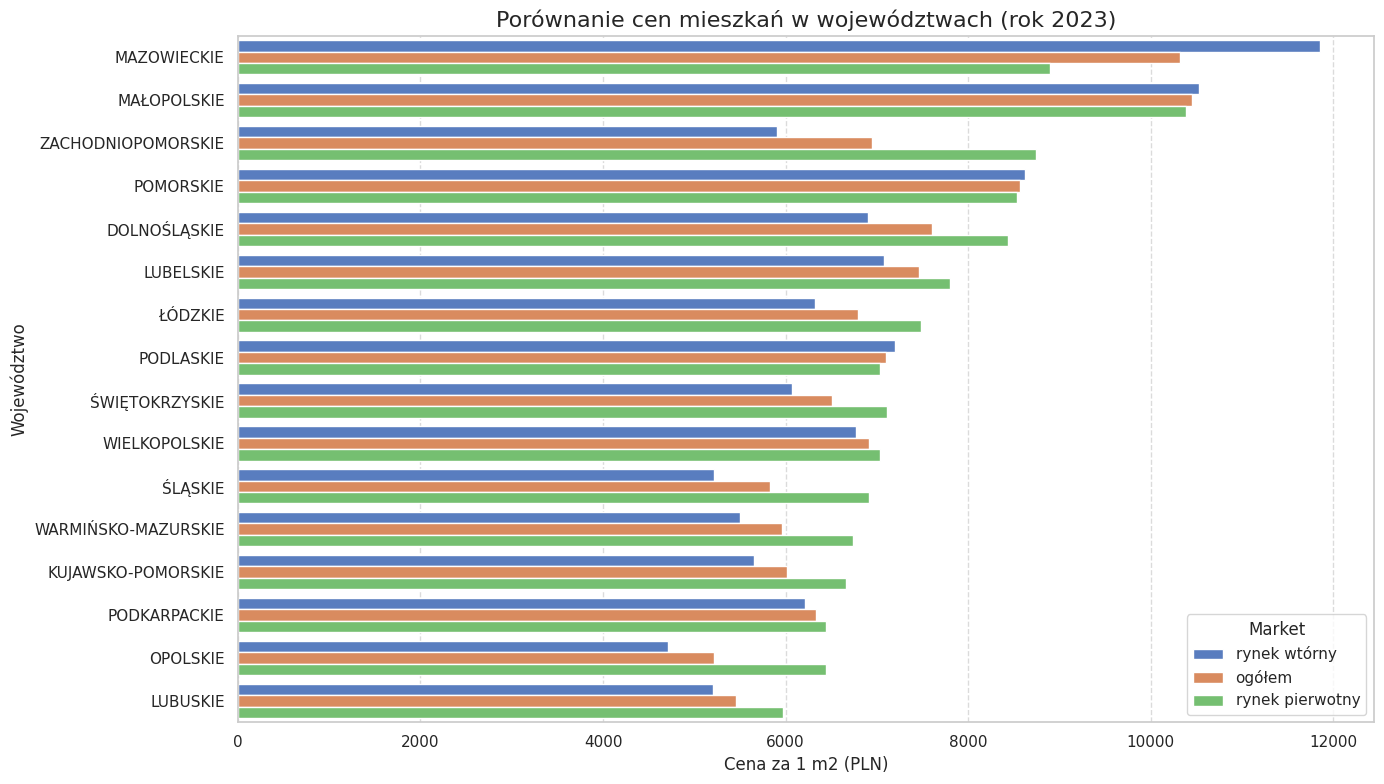

WNIOSKI: W 2023 roku różnice regionalne są drastyczne – Mazowieckie dominuje nad resztą stawki.
Wysoka cena na rynku pierwotnym w topowych województwach sugeruje silną koncentrację
inwestycji deweloperskich w najbogatszych regionach kraju.


In [17]:
voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

df_voivodeships = df_clean[df_clean['Nazwa'].isin(voivodeships)]
average_prices_by_voivodeship = df_voivodeships.groupby('Nazwa')['cena_numeric'].mean().reset_index()

styled_table = average_prices_by_voivodeship.style\
    .background_gradient(cmap='Greens', subset=['cena_numeric']) \
    .set_properties(**{'border-color': '#0a0a0a', 'border-style': 'solid', 'border-width': '1px'}) \
    .set_table_styles([{'selector': 'td, th', 'props': [('border', '1px solid #0a0a0a')]}])

print("Średnie ceny nieruchomości dla województw")
display(styled_table)

df_processed = df.copy()
df_processed.rename(columns={'Nazwa': 'Region', 'Transakcje rynkowe': 'Market', 'Rok': 'Year', 'Wartosc': 'Price'}, inplace=True)
df_processed['Price'] = pd.to_numeric(df_processed['Price'], errors='coerce')
df_processed = df_processed[df_processed['Price'] > 0]

latest_year = 2023
df_2023 = df_processed[(df_processed['Region'].isin(voivodeships)) & (df_processed['Year'] == latest_year)].copy()

summary_pivot = df_2023.pivot(index='Region', columns='Market', values='Price')
summary_pivot['Różnica (P-W)'] = summary_pivot['rynek pierwotny'] - summary_pivot['rynek wtórny']
summary_pivot = summary_pivot.sort_values(by='rynek pierwotny', ascending=False)

plt.figure(figsize=(14, 8))
df_plot = df_2023.sort_values(by='Price', ascending=False)
sns.barplot(data=df_plot, y='Region', x='Price', hue='Market', palette='muted')
plt.title(f'Porównanie cen mieszkań w województwach (rok {latest_year})', fontsize=16)
plt.xlabel('Cena za 1 m2 (PLN)', fontsize=12)
plt.ylabel('Województwo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(f"WNIOSKI: W 2023 roku różnice regionalne są drastyczne – Mazowieckie dominuje nad resztą stawki.")
print("Wysoka cena na rynku pierwotnym w topowych województwach sugeruje silną koncentrację")
print("inwestycji deweloperskich w najbogatszych regionach kraju.")

------------------------------------------------------------


,Województwo,Najdroższy Powiat,Cena Max [zł/m2],Najtańszy Powiat,Cena Min [zł/m2]
0,DOLNOŚLĄSKIE,Powiat m. Wrocław,10151,Powiat górowski,2591
1,KUJAWSKO-POMORSKIE,Powiat m. Toruń,7545,Powiat grudziądzki,3031
2,LUBELSKIE,Powiat m. Lublin,8593,Powiat zamojski,2892
3,LUBUSKIE,Powiat m. Zielona Góra,6708,Powiat żagański,3440
4,ŁÓDZKIE,Powiat m. Łódź,7365,Powiat skierniewicki,2927
5,MAŁOPOLSKIE,Powiat tatrzański,16104,Powiat suski,4466
6,MAZOWIECKIE,Powiat m. st. Warszawa,13498,Powiat przysuski,3800
7,OPOLSKIE,Powiat m. Opole,7140,Powiat głubczycki,2919
8,PODKARPACKIE,Powiat m. Rzeszów,7612,Powiat lubaczowski,2874
9,PODLASKIE,Powiat m. Białystok,7899,Powiat suwalski,3110


------------------------------------------------------------


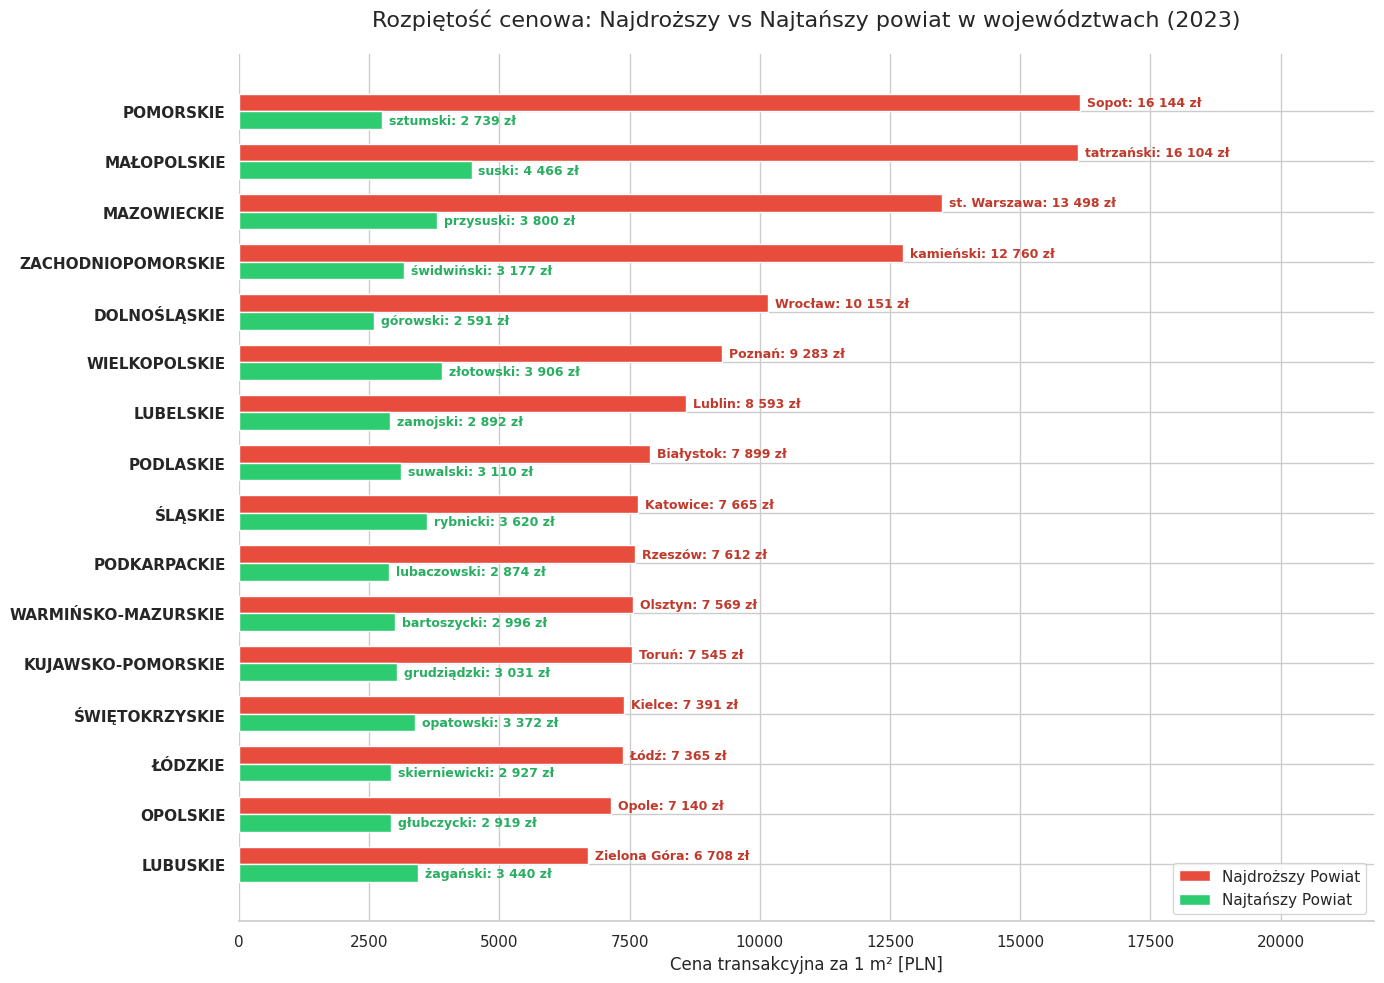

WNIOSKI: Wykres uwidacznia ogromną polaryzację wewnątrzwojewódzką.
Średnia cena wojewódzka jest silnie zawyżana przez stolice regionów, podczas gdy
powiaty peryferyjne oferują nieruchomości nawet o połowę tańsze w tym samym województwie.


In [18]:
# Analiza najdroższych i najtańszych powiatów
df['Wartosc'] = df['Wartosc'].astype(str).str.replace(' ', '')
df['Wartosc'] = pd.to_numeric(df['Wartosc'].replace('-', np.nan), errors='coerce')

print("------------------------------------------------------------")
df['Wojewodztwo'] = df['Nazwa'].apply(lambda x: x if x in voivodeships else np.nan).ffill()
mask = (
    (df['Rok'] == 2023) &
    (df['Transakcje rynkowe'] == 'ogółem') &
    (~df['Nazwa'].isin(voivodeships)) &
    (df['Nazwa'] != 'POLSKA') &
    (df['Nazwa'].str.contains('Powiat', na=False))
)
df_2023_pow = df[mask].copy()

wyniki = []
for woj in df_2023_pow['Wojewodztwo'].unique():
    grupa = df_2023_pow[df_2023_pow['Wojewodztwo'] == woj]
    if grupa.empty: continue
    najdrozszy = grupa.loc[grupa['Wartosc'].idxmax()]
    najtanszy = grupa.loc[grupa['Wartosc'].idxmin()]
    wyniki.append({
        'Województwo': woj,
        'Najdroższy Powiat': najdrozszy['Nazwa'],
        'Cena Max [zł/m2]': najdrozszy['Wartosc'],
        'Najtańszy Powiat': najtanszy['Nazwa'],
        'Cena Min [zł/m2]': najtanszy['Wartosc']
    })

df_wynik = pd.DataFrame(wyniki)
display(df_wynik)

print("------------------------------------------------------------")
df_wynik['Cena Max [zł/m2]'] = pd.to_numeric(df_wynik['Cena Max [zł/m2]'])
df_wynik['Cena Min [zł/m2]'] = pd.to_numeric(df_wynik['Cena Min [zł/m2]'])
df_plot_pow = df_wynik.sort_values('Cena Max [zł/m2]', ascending=True)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 10))
y = np.arange(len(df_plot_pow))
height = 0.35

rects_max = ax.barh(y + height/2, df_plot_pow['Cena Max [zł/m2]'], height, label='Najdroższy Powiat', color='#e74c3c', edgecolor='white')
rects_min = ax.barh(y - height/2, df_plot_pow['Cena Min [zł/m2]'], height, label='Najtańszy Powiat', color='#2ecc71', edgecolor='white')

def dodaj_etykiety(rects, nazwy_powiatow, kolor):
    for rect, nazwa in zip(rects, nazwy_powiatow):
        width = rect.get_width()
        nazwa_krotka = nazwa.replace('Powiat ', '').replace('m. ', '')
        label_text = f'{nazwa_krotka}: {int(width):,} zł'.replace(',', ' ')
        ax.annotate(label_text, xy=(width, rect.get_y() + rect.get_height() / 2), xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=9, fontweight='bold', color=kolor)

dodaj_etykiety(rects_max, df_plot_pow['Najdroższy Powiat'], '#c0392b')
dodaj_etykiety(rects_min, df_plot_pow['Najtańszy Powiat'], '#27ae60')

ax.set_yticks(y)
ax.set_yticklabels(df_plot_pow['Województwo'], fontsize=11, fontweight='bold')
ax.set_xlabel('Cena transakcyjna za 1 m² [PLN]', fontsize=12)
ax.set_title('Rozpiętość cenowa: Najdroższy vs Najtańszy powiat w województwach (2023)', fontsize=16, pad=20)
ax.legend(loc='lower right', frameon=True)
sns.despine(left=True, bottom=False)
ax.set_xlim(0, df_plot_pow['Cena Max [zł/m2]'].max() * 1.35)
plt.tight_layout()
plt.show()
print("WNIOSKI: Wykres uwidacznia ogromną polaryzację wewnątrzwojewódzką.")
print("Średnia cena wojewódzka jest silnie zawyżana przez stolice regionów, podczas gdy")
print("powiaty peryferyjne oferują nieruchomości nawet o połowę tańsze w tym samym województwie.")

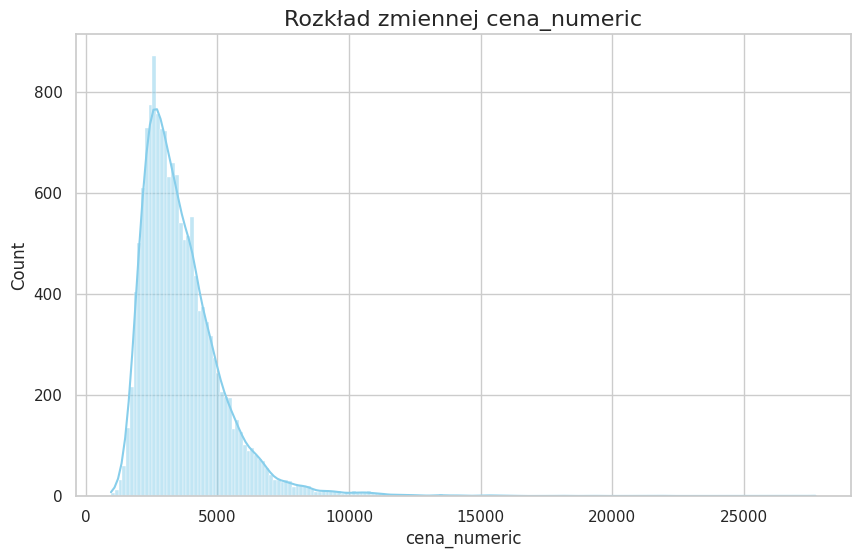

WNIOSKI: Rozkład zmiennej cena_numeric wykazuje asymetrię prawostronną.
Długi 'ogon' po prawej stronie wskazuje na to, że testy oparte na średniej mogą być
obciążone przez segmenty luksusowe, co sugeruje użycie statystyk odpornych.


In [27]:
# 8. Sprawdzenie założeń
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['cena_numeric'], kde=True, color='skyblue')
plt.title('Rozkład zmiennej cena_numeric', fontsize=16)
plt.show()
print("WNIOSKI: Rozkład zmiennej cena_numeric wykazuje asymetrię prawostronną.")
print("Długi 'ogon' po prawej stronie wskazuje na to, że testy oparte na średniej mogą być")
print("obciążone przez segmenty luksusowe, co sugeruje użycie statystyk odpornych.")

<Figure size 800x600 with 0 Axes>

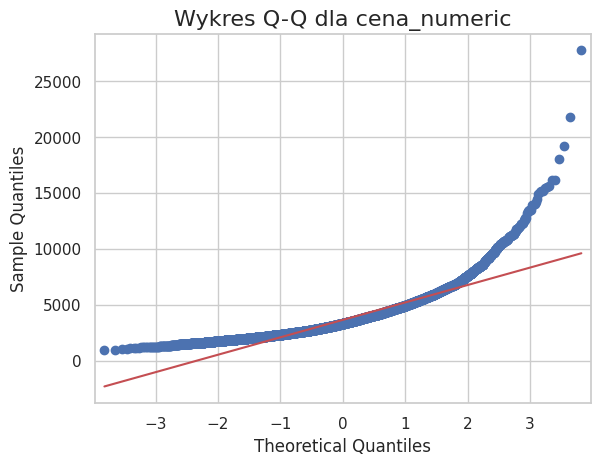

WNIOSKI: Odchylenia punktów od linii prostej na wykresie Q-Q potwierdzają brak normalności.
Szczególnie 'ciężkie ogony' rozkładu dowodzą, że założenia klasycznej ANOVA nie są tutaj spełnione.


In [28]:
#Wykres Q-Q dla cena_numeric
plt.figure(figsize=(8, 6))
sm.qqplot(df_clean['cena_numeric'], line='s')
plt.title('Wykres Q-Q dla cena_numeric', fontsize=16)
plt.show()
print("WNIOSKI: Odchylenia punktów od linii prostej na wykresie Q-Q potwierdzają brak normalności.")
print("Szczególnie 'ciężkie ogony' rozkładu dowodzą, że założenia klasycznej ANOVA nie są tutaj spełnione.")


Test Shapiro-Wilka dla 'cena_numeric':
Statystyka testowa = 0.8537, p-wartość = 0.0000


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14996.
  res = hypotest_fun_out(*samples, **kwds)


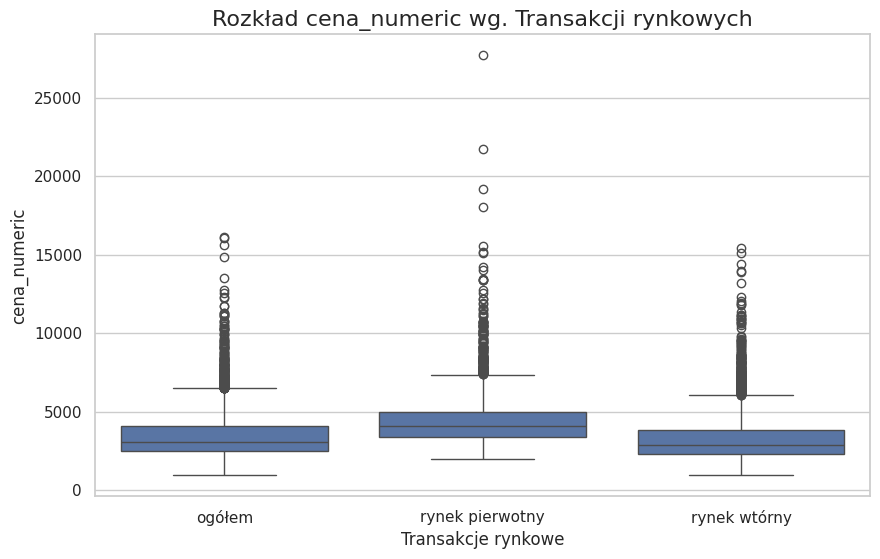

WNIOSKI: Różnice w rozmiarach pudełek sugerują heteroskedastyczność (brak jednorodności wariancji).
Wariancja cen na rynku pierwotnym jest wyższa, co wynika z różnorodnego standardu deweloperskiego.


In [29]:
#Test Shapiro-Wilka
shapiro_test = stats.shapiro(df_clean['cena_numeric'])
print(f"\nTest Shapiro-Wilka dla 'cena_numeric':\nStatystyka testowa = {shapiro_test.statistic:.4f}, p-wartość = {shapiro_test.pvalue:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Transakcje rynkowe', y='cena_numeric')
plt.title('Rozkład cena_numeric wg. Transakcji rynkowych', fontsize=16)
plt.show()
print("WNIOSKI: Różnice w rozmiarach pudełek sugerują heteroskedastyczność (brak jednorodności wariancji).")
print("Wariancja cen na rynku pierwotnym jest wyższa, co wynika z różnorodnego standardu deweloperskiego.")

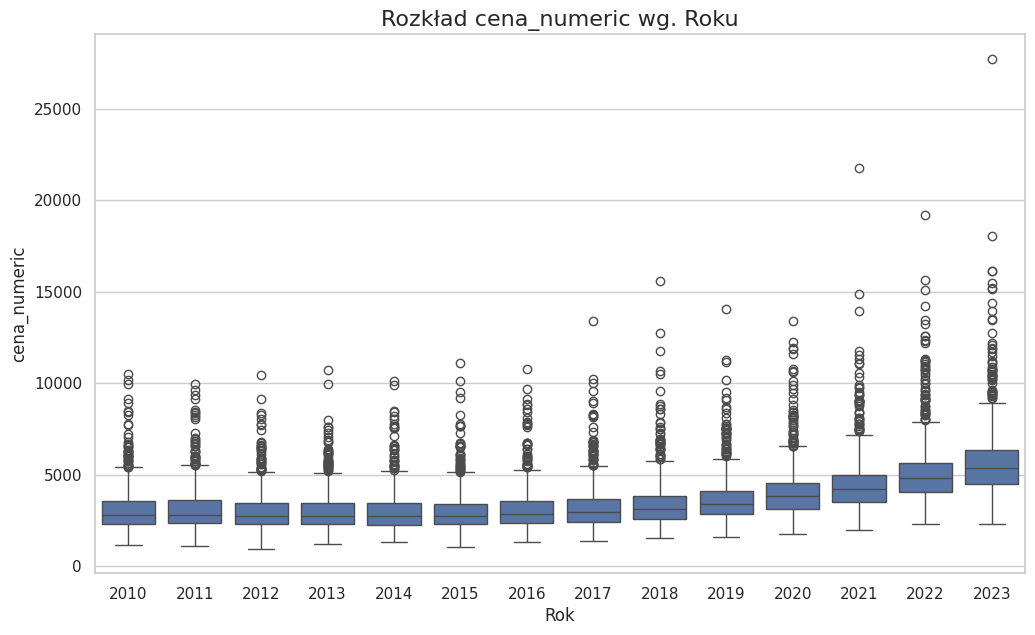

WNIOSKI: Wraz z upływem lat rośnie nie tylko średnia cena, ale i jej zmienność (wariancja).
Wizualnie potwierdza to naruszenie założenia o jednorodności wariancji w czasie.


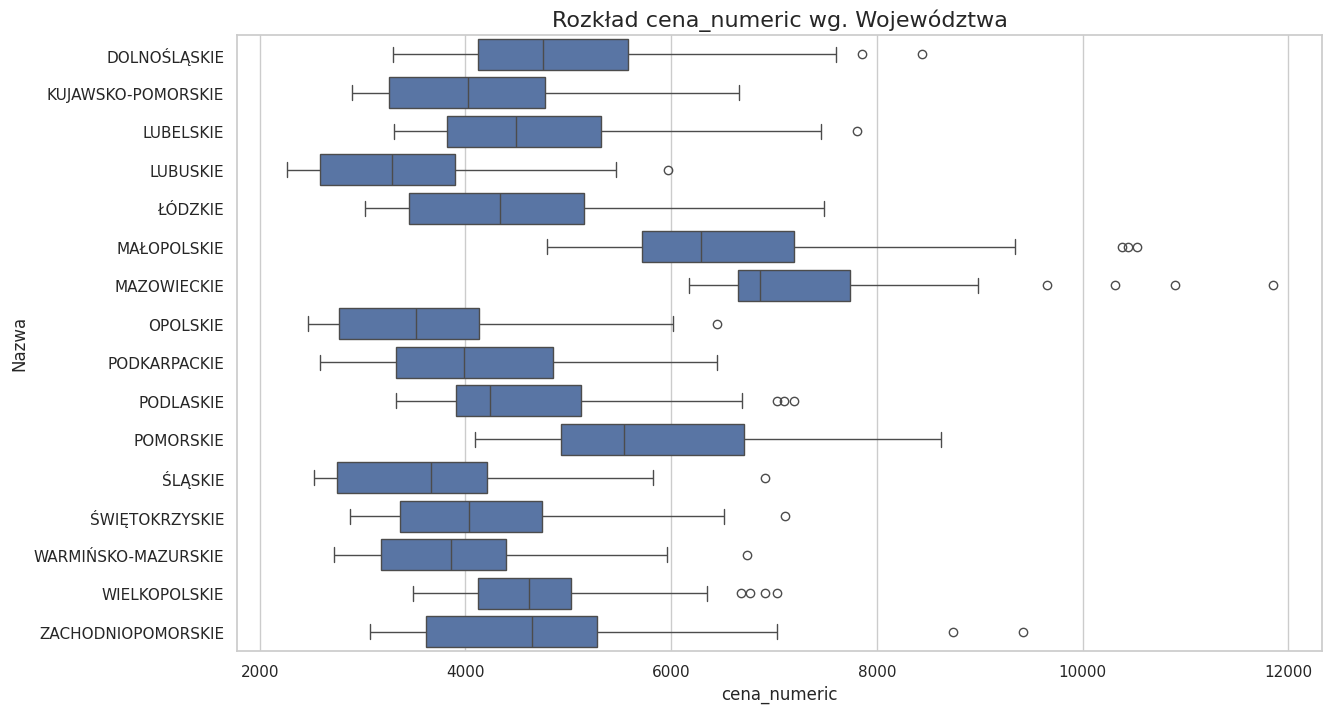

WNIOSKI: Rozkłady wewnątrzwojewódzkie różnią się istotnie pod względem szerokości.
Potwierdza to konieczność stosowania testu Welch's ANOVA, który jest odporny na brak równości wariancji.

Test Levene'a dla 'Transakcje rynkowe':
Statystyka testowa = 6.5595, p-wartość = 0.0014

Test Levene'a dla 'Rok':
Statystyka testowa = 24.7711, p-wartość = 0.0000


In [25]:
#Rozkład cena_numeric wg. Roku
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_clean, x='Rok', y='cena_numeric')
plt.title('Rozkład cena_numeric wg. Roku', fontsize=16)
plt.show()
print("WNIOSKI: Wraz z upływem lat rośnie nie tylko średnia cena, ale i jej zmienność (wariancja).")
print("Wizualnie potwierdza to naruszenie założenia o jednorodności wariancji w czasie.")

df_voivodeships_outliers = df_clean[df_clean['Nazwa'].isin(voivodeships)].copy()
if not df_voivodeships_outliers.empty:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_voivodeships_outliers, x='cena_numeric', y='Nazwa')
    plt.title('Rozkład cena_numeric wg. Województwa', fontsize=16)
    plt.show()
    print("WNIOSKI: Rozkłady wewnątrzwojewódzkie różnią się istotnie pod względem szerokości.")
    print("Potwierdza to konieczność stosowania testu Welch's ANOVA, który jest odporny na brak równości wariancji.")

groups_market = [df_clean['cena_numeric'][df_clean['Transakcje rynkowe'] == cat] for cat in df_clean['Transakcje rynkowe'].unique()]
levene_market = stats.levene(*groups_market)
print(f"\nTest Levene'a dla 'Transakcje rynkowe':\nStatystyka testowa = {levene_market.statistic:.4f}, p-wartość = {levene_market.pvalue:.4f}")

groups_rok = [df_clean['cena_numeric'][df_clean['Rok'] == r] for r in df_clean['Rok'].unique()]
levene_rok = stats.levene(*groups_rok)
print(f"\nTest Levene'a dla 'Rok':\nStatystyka testowa = {levene_rok.statistic:.4f}, p-wartość = {levene_rok.pvalue:.4f}")


--- Welch's ANOVA dla 'Transakcje rynkowe' ---
statistic = 734.1931526867207
pvalue = 4.1509726435591815e-297
df = (2.0, np.float64(9449.277878609888))
df_num = 2.0
df_denom = 9449.277878609888
nobs_t = 14996.0
n_groups = 3
means = [3451.76784731 4419.50987564 3261.26900477]
nobs = [5449. 4101. 5446.]
vars_ = [2144242.32733606 2494153.47045123 2022961.72064426]
use_var = unequal
welch_correction = True
tuple = (np.float64(734.1931526867207), np.float64(4.1509726435591815e-297))

--- Welch's ANOVA dla 'Rok' ---
statistic = 338.3198353703691
pvalue = 0.0
df = (13.0, np.float64(5753.512224748787))
df_num = 13.0
df_denom = 5753.512224748787
nobs_t = 14996.0
n_groups = 14
means = [3078.05170631 3114.72306143 3009.35443038 2978.60153257 2982.49000951
     2996.62488129 3091.66510758 3186.41866913 3379.23566879 3631.02350814
     4016.49863512 4446.63384064 5073.60544815 5644.73153779]
nobs = [ 967.  993. 1027. 1044. 1051. 1053. 1069. 1082. 1099. 1106. 1099. 1117.
     1138. 1151.]
vars_ = [

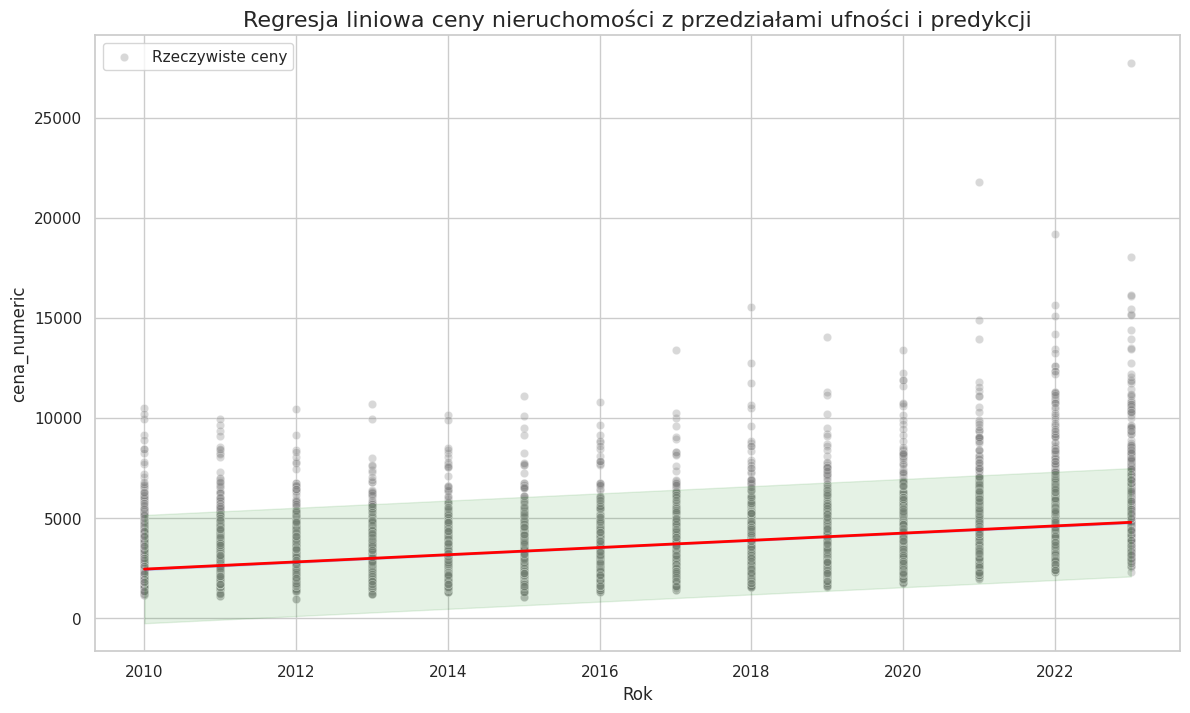

WNIOSKI: Model regresji wykazuje silną korelację dodatnią czasu z ceną.
Szeroki zielony obszar (przedział predykcji) dowodzi jednak, że zmienna czasowa wyjaśnia
jedynie trend ogólny, a nie cenę konkretnej nieruchomości, która zależy od wielu innych czynników.


In [20]:
# 9. Robust ANOVA
print("\n--- Welch's ANOVA dla 'Transakcje rynkowe' ---")
groups_market_welch = [df_clean['cena_numeric'][df_clean['Transakcje rynkowe'] == cat] for cat in df_clean['Transakcje rynkowe'].unique()]
anova_market = anova_oneway(groups_market_welch, use_var='unequal')
print(anova_market)

print("\n--- Welch's ANOVA dla 'Rok' ---")
groups_rok_welch = [df_clean['cena_numeric'][df_clean['Rok'] == r] for r in df_clean['Rok'].unique()]
anova_rok = anova_oneway(groups_rok_welch, use_var='unequal')
print(anova_rok)

print("\n--- Welch's ANOVA dla 'Nazwa' (województwa) ---")
if not df_voivodeships_outliers.empty:
    groups_nazwa_welch = [df_voivodeships_outliers['cena_numeric'][df_voivodeships_outliers['Nazwa'] == n] for n in df_voivodeships_outliers['Nazwa'].unique()]
    anova_nazwa = anova_oneway(groups_nazwa_welch, use_var='unequal')
    print(anova_nazwa)

# Regresja
model = smf.ols('cena_numeric ~ Rok', data=df_clean)
results = model.fit()
print(results.summary())

min_rok = df_clean['Rok'].min()
max_rok = df_clean['Rok'].max()
pred_years = pd.DataFrame({'Rok': np.arange(min_rok, max_rok + 1)})
predictions = results.get_prediction(pred_years)
pred_summary = predictions.summary_frame(alpha=0.05)

plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_clean, x='Rok', y='cena_numeric', alpha=0.3, label='Rzeczywiste ceny', color='gray')
plt.plot(pred_years['Rok'], pred_summary['mean'], color='red', linewidth=2, label='Linia regresji (predykcja)')
plt.fill_between(pred_years['Rok'], pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='blue', alpha=0.2, label='95% Przedział ufności dla średniej')
plt.fill_between(pred_years['Rok'], pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'], color='green', alpha=0.1, label='95% Przedział predykcji dla obserwacji')
plt.title('Regresja liniowa ceny nieruchomości z przedziałami ufności i predykcji', fontsize=16)
plt.show()
print("WNIOSKI: Model regresji wykazuje silną korelację dodatnią czasu z ceną.")
print("Szeroki zielony obszar (przedział predykcji) dowodzi jednak, że zmienna czasowa wyjaśnia")
print("jedynie trend ogólny, a nie cenę konkretnej nieruchomości, która zależy od wielu innych czynników.")

In [24]:
# Raport końcowy
raport_tekst = """
# Raport końcowy: Analiza rynku nieruchomości w Polsce

## 1. Wstęp i przygotowanie danych
Celem analizy było zbadanie struktury cenowej mieszkań. Kluczowym etapem było usunięcie błędnych wartości zerowych oraz zastosowanie metody IQR. Dzięki temu wyeliminowano skrajne odchylenia (outliery), co pozwoliło na rzetelną ocenę typowych transakcji rynkowych bez wpływu ekstremalnie drogich apartamentów.

## 2. Analiza eksploracyjna (EDA) i trendy
* **Segmentacja i zmienność:** Rynek pierwotny jest nie tylko droższy, ale wykazuje znacznie większą wariancję (szersze pudełka na wykresie boxplot). Oznacza to, że oferta deweloperska jest bardziej zróżnicowana cenowo niż rynek wtórny.
* **Dynamika trendu:** Wykresy liniowe wskazują na punkt przegięcia w okolicach 2017 roku, po którym nastąpił gwałtowny wzrost cen. Rynek pierwotny i wtórny rosną niemal równolegle, zachowując stałą lukę cenową.
* **Analiza regionalna:** Województwa mazowieckie i małopolskie liderują pod względem cen, jednak wykresy powiatowe ujawniają drastyczne dysproporcje – wewnątrz jednego regionu różnica między najdroższym a najtańszym powiatem jest często dwukrotna.

## 3. Wnioskowanie statystyczne
* **Weryfikacja założeń:** Testy Shapiro-Wilka (normalność) oraz Levene'a (wariancja) dały wyniki istotne statystycznie ($p < 0.05$), co oznacza naruszenie klasycznych założeń. Rozkład cen jest prawostronnie asymetryczny, a zmienność cen rośnie wraz z upływem lat (heteroskedastyczność).
* **Testy odporne:** Wykorzystanie Welch's ANOVA potwierdziło, że typ rynku, rok oraz lokalizacja są niezależnymi, silnymi determinantami cen, a zaobserwowane różnice między nimi nie są dziełem przypadku.

## 4. Modelowanie (Regresja liniowa)
Model OLS matematycznie potwierdza trend wzrostowy. Wizualizacja przedziałów pokazuje wąski margines błędu dla średniej ceny, ale bardzo szeroki przedział predykcji dla pojedynczych obserwacji. Oznacza to, że model świetnie przewiduje kierunek rynku, ale sam rok to za mało, by precyzyjnie wycenić konkretne mieszkanie.

## 5. Podsumowanie
Rynek nieruchomości staje się coraz bardziej złożony i zmienny. Wysoka wariancja w ostatnich latach sugeruje większe ryzyko inwestycyjne. Kluczowym wnioskiem jest konieczność analizy lokalnej – średnie wojewódzkie są mocno zawyżane przez stolice regionów, co maskuje znacznie niższe ceny w powiatach ościennych.
"""
display(Markdown(raport_tekst))


# Raport końcowy: Analiza rynku nieruchomości w Polsce

## 1. Wstęp i przygotowanie danych
Celem analizy było zbadanie struktury cenowej mieszkań. Kluczowym etapem było usunięcie błędnych wartości zerowych oraz zastosowanie metody IQR. Dzięki temu wyeliminowano skrajne odchylenia (outliery), co pozwoliło na rzetelną ocenę typowych transakcji rynkowych bez wpływu ekstremalnie drogich apartamentów.

## 2. Analiza eksploracyjna (EDA) i trendy
* **Segmentacja i zmienność:** Rynek pierwotny jest nie tylko droższy, ale wykazuje znacznie większą wariancję (szersze pudełka na wykresie boxplot). Oznacza to, że oferta deweloperska jest bardziej zróżnicowana cenowo niż rynek wtórny.
* **Dynamika trendu:** Wykresy liniowe wskazują na punkt przegięcia w okolicach 2017 roku, po którym nastąpił gwałtowny wzrost cen. Rynek pierwotny i wtórny rosną niemal równolegle, zachowując stałą lukę cenową.
* **Analiza regionalna:** Województwa mazowieckie i małopolskie liderują pod względem cen, jednak wykresy powiatowe ujawniają drastyczne dysproporcje – wewnątrz jednego regionu różnica między najdroższym a najtańszym powiatem jest często dwukrotna.

## 3. Wnioskowanie statystyczne
* **Weryfikacja założeń:** Testy Shapiro-Wilka (normalność) oraz Levene'a (wariancja) dały wyniki istotne statystycznie ($p < 0.05$), co oznacza naruszenie klasycznych założeń. Rozkład cen jest prawostronnie asymetryczny, a zmienność cen rośnie wraz z upływem lat (heteroskedastyczność).
* **Testy odporne:** Wykorzystanie Welch's ANOVA potwierdziło, że typ rynku, rok oraz lokalizacja są niezależnymi, silnymi determinantami cen, a zaobserwowane różnice między nimi nie są dziełem przypadku.

## 4. Modelowanie (Regresja liniowa)
Model OLS matematycznie potwierdza trend wzrostowy. Wizualizacja przedziałów pokazuje wąski margines błędu dla średniej ceny, ale bardzo szeroki przedział predykcji dla pojedynczych obserwacji. Oznacza to, że model świetnie przewiduje kierunek rynku, ale sam rok to za mało, by precyzyjnie wycenić konkretne mieszkanie.

## 5. Podsumowanie 
Rynek nieruchomości staje się coraz bardziej złożony i zmienny. Wysoka wariancja w ostatnich latach sugeruje większe ryzyko inwestycyjne. Kluczowym wnioskiem jest konieczność analizy lokalnej – średnie wojewódzkie są mocno zawyżane przez stolice regionów, co maskuje znacznie niższe ceny w powiatach ościennych.
